# I Know You Got The Feels: Predicting Stock Index Using GDELT v2 Events Daily Average Tone

## 1. Executive Summary

<p style="text-align:justify">News headlines serve as flagships for the events that dictate the rise and crash of equity as the stock market is held under the pervasive influence of media. This begs the question of: how we can use the availability of news information to methodically quantify the effect of media on a company’s stock price? Using data freely available from the GDELT project and Yahoo Finance, this study leveraged Amazon Web Services as a platform for Pyspark which the authors utilized to combine company stock price information and an aggregated media tone from several reports coming from different news sources. The Closing Price for several companies was then modelled using the Merlion Time Series DefaultForecaster using an 80% Train and 20% Test split. Tesla Stock produced a MAE of 2.47 when the cumulative sum of the daily media tone from different sources is included as feature and forecasted using the last value of a 3-Day Sliding Prediction Window. When back testing is utilized with the model’s prediction, the study produces a return of -9.64 compared to -61.67 when using moving averages, showing definite improvement. To further refine the results coming from this study, the authors suggest the following: keyword choice augmentation when scraping web articles from the GDELT project, a granular incorporation of long and short range data coming also coming from GDELT, pre-processing steps and hyperparameter tuning for the Time Series models utilized, and finally, company profiling to refine the selection criteria of entities suited for this methodology.</p>

In [1]:
from datetime import datetime
import math 

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
from IPython.display import HTML
from IPython.display import Image as _image

import pickle
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

plotly.offline.init_notebook_mode()

COLORS = ['#4db4d7']

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4hp8vbvk because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/msds2022/casoriano/.local/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## 2. Problem Statement

_How might we measure the effect of media sentiments on stock prices?_

## 3. Motivation

<p style="text-align:justify">Systematic risk represents the volatility and dynamics of the stock market reliant on factors outside of the companies involved such as government policy and mass media. It is unpredictable and impossible to completely avoid. Therefore, there is benefit in being able to incorporate this in models used to predict the stock index. [3]</p>

<p style="text-align:justify">Mass media acts as a representation of systematic risk, as its influence is pervasive throughout society and its institutions, the stock market included. Our study wanted to see how much influence mass media has in forecasting the closing price of a company's stock. For example, continuous negative press on a company can influence its stock price to go down continuously throughout that period. Being able to predict the early signs of the downtrend can mean selling early and net loss is minimized.</p>

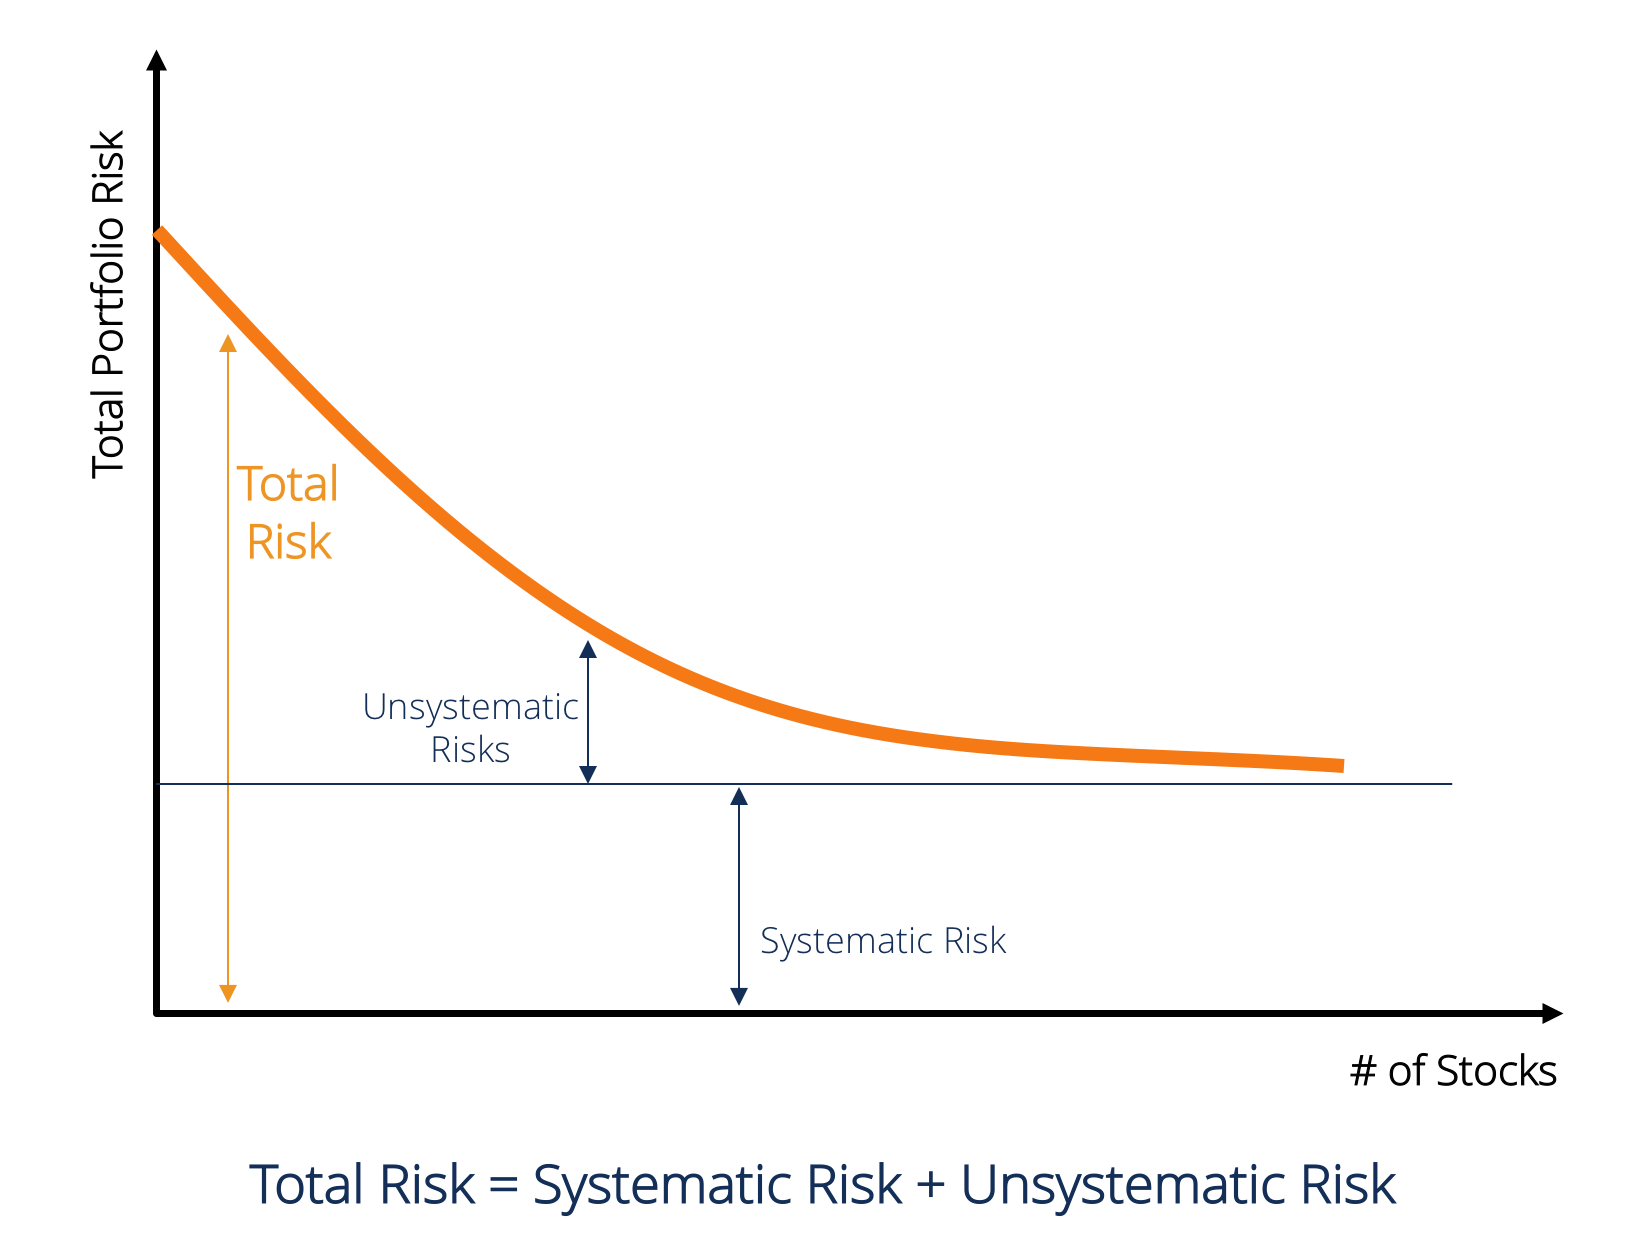

In [2]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 1. Portfolio Risk.
</b></center>'''))

display(_image(filename="img/risk.png"))

## 4. Data Source

<p style="text-align:justify">The GDELT project has almost 250 million event record for a worldwide range of categories from 1979 up to the present. It is a network connecting each record’s themes, locations, personalities, organizations, and locations with corresponding emotional assessments. It is meant to be a repository and a representation of the world’s behavior recorded through events. It covers most of the world events and provide details such as people or groups involved, its context and what tone the record reflects. Different media such as broadcast, print, and web news released by several media sources worldwide are recorded[1].</p>

<p style="text-align:justify">The dataset used for this study is the events dataset which has over 143,000 files and is 102 GB in size. The events dataset is a table updated every 15 minutes. The dataset in the AWS open registry covers data from 2015 to Q1 2019. GDELT events dataset has several features, 61 in total, but we chose the following features to be in the final dataset:</p>

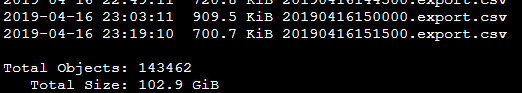

In [3]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 2. Initial Data Size Scan.
</b></center>'''))

display(_image(filename="img/datasize.png"))

<p style="text-align:justify">The <b>average tone</b> serves as the key feature to forecast a company’s stock price in this study. It is the average “tone” of all documents containing one or more mentions of this event. The common values range between -10 and +10, with 0 indicating neutral.  It is used for filtering the “context” of events as a subtle measure of the importance of an event and as a proxy for the “impact” of that event.  This provides only a basic tonal assessment of an article. This also ranges from -100 to 100. [2]</p>

<p style="text-align:justify">For the corresponding stock information for each company analyzed, we utilized Yahoo Finance which is one of the largest sources of stock quotes and other financial information available. It holds information for over 37 thousand stocks for over 50 countries.</p>

<center style="font-size:12px;font-style:default;"><b>
Table 1. GDELT Chosen Feature List
</b></center>

| Feature Name | Description |
| :- | :- |
| Date Added | stores the date the event was added to the master database |
| Actor1Name | first of two actors involved in the event. It could be proper or formal names, names of countries and cities, ethnic groups, religious groups, etc |
| Actor2Name | second of two actors involved in the event. It could be proper or formal names, names of countries and cities, ethnic groups, religious groups, etc |
| URL | the URL or citation of the news report the event was found in |
| Average Tone | a quantitative measure of the positive, negative, or neutral sentiment for the event record |

## 5. Data Exploration

### 5.1 Plot of time series of tone

<p style="text-align:justify">Let us visualize the average tone score and cumulative average tone score of the companies for each year to get the trend of the sentiments for the written artciles.</p>

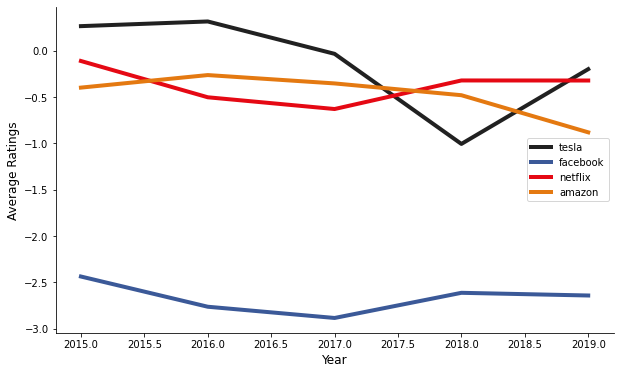

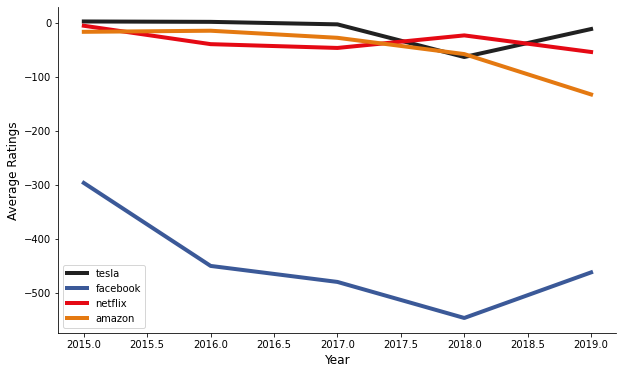

In [4]:
tesla_tone = pd.read_csv('data/tesla.csv')
fb_tone = pd.read_csv('data/facebook.csv')
nf_tone = pd.read_csv('data/netflix.csv')
amzn_tone = pd.read_csv('data/amazon.csv')

for tone in [tesla_tone, fb_tone, nf_tone, amzn_tone]:
    tone['Date'] = (tone['DATEADDED'].astype('str')
                                     .apply(lambda x: datetime(int(x[:4]), 
                                                      int(x[4:6]), 
                                                      int(x[6:]))))
    tone.drop('DATEADDED', axis=1, inplace=True)
    tone['year'] = tone.Date.dt.year.astype('int')
    tone = tone.groupby('year')['Daily Average Tone'].mean()

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 3. Plots of time series tone score.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Average Yearly<b style="color:{COLORS[0]}">
                 tone score</b>  of the companies
                </h3>'''))

fig, ax = plt.subplots(figsize=(10, 6))
names = ['tesla', 'facebook', 'netflix', 'amazon']
colors = ['#212121', '#3b5998', '#e50914', '#e47911']
for tone, name, color in zip([tesla_tone, fb_tone, nf_tone, 
                       amzn_tone], names, colors):
    (tone.groupby('year')['Daily Average Tone'].mean()
         .plot(color=color, lw=4, ax=ax, label=name))
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Ratings", fontsize=12)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    
plt.show()

tesla_cumsum_tone = pd.read_csv('data/tesla_cumsum.csv')
fb_cumsum_tone = pd.read_csv('data/facebook_cumsum.csv')
nf_cumsum_tone = pd.read_csv('data/netflix_cumsum.csv')
amzn_cumsum_tone = pd.read_csv('data/amazon_cumsum.csv')

for tone in [tesla_cumsum_tone, fb_cumsum_tone, 
             nf_cumsum_tone, amzn_cumsum_tone]:
    tone['Date'] = (tone['DATEADDED'].astype('str')
                                     .apply(lambda x: datetime(int(x[:4]), 
                                                      int(x[4:6]), 
                                                      int(x[6:]))))
    tone.drop('DATEADDED', axis=1, inplace=True)
    tone['year'] = tone.Date.dt.year.astype('int')
    tone = tone.groupby('year')['Daily Average Tone'].mean()
    
display(HTML(f'''<h3 style="text-align:center">
                Average yearly<b style="color:{COLORS[0]}">
                cumulative tone score</b>  of the companies
                </h3>'''))

fig, ax = plt.subplots(figsize=(10, 6))
names = ['tesla', 'facebook', 'netflix', 'amazon']
colors = ['#212121', '#3b5998', '#e50914', '#e47911']
for tone, name, color in zip([tesla_cumsum_tone, fb_cumsum_tone, 
                              nf_cumsum_tone, amzn_cumsum_tone], 
                             names, colors):
    (tone.groupby('year')['Daily Average Tone'].mean()
         .plot(color=color, lw=4, ax=ax, label=name))
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Ratings", fontsize=12)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    
plt.show()

<p style="text-align:justify">We can observe that Tesla has always been consistent at the top of the tone score except for the 2018 where there is a news about its owner Elon Musk over fraud charges and news about the Tesla car crash during its autopilot. Aside from that year, it remained to the top of the tone scores. We can also see that Facebook is far behind at the bottom in terms of the tone score. Overall, most of these big companies have negative tone score of news articles</p>

### 5.2 Plot of time series of stocks

<p style="text-align:justify">Let us also visualize the actual performance of stocks during the same period of study from 2015 to 2019.</p>

In [5]:
def show_candlesticks(df, symbols='All'):
    """
    Figure that shows the candlesticks of a market
    Parameters
    ===========
    df                  dataframe 
                        object having data 
    symbol              list 
                        symbols you want to graph (recommended 1 symbol only)
    """
    # create figure object for suplots
    fig = make_subplots(rows=1, 
                      cols=1,
                      subplot_titles=[symbols])
    # update figure size
    fig.update_layout(
    autosize = False,
    width = 950 * 1,
    height = 500 * 1,
    paper_bgcolor = "LightSteelBlue"
    )

    # loop through all the symbols needed to plot
    row = 1
    col = 1
    df_market = df.copy()
    fig.add_trace(
        go.Candlestick(x=df.index,
                  open=df_market['Open'],
                  high=df_market['High'],
                  low=df_market['Low'],
                  close=df_market['Close'], 
                  ),
                  row=row, col=col
        );


    fig.show();

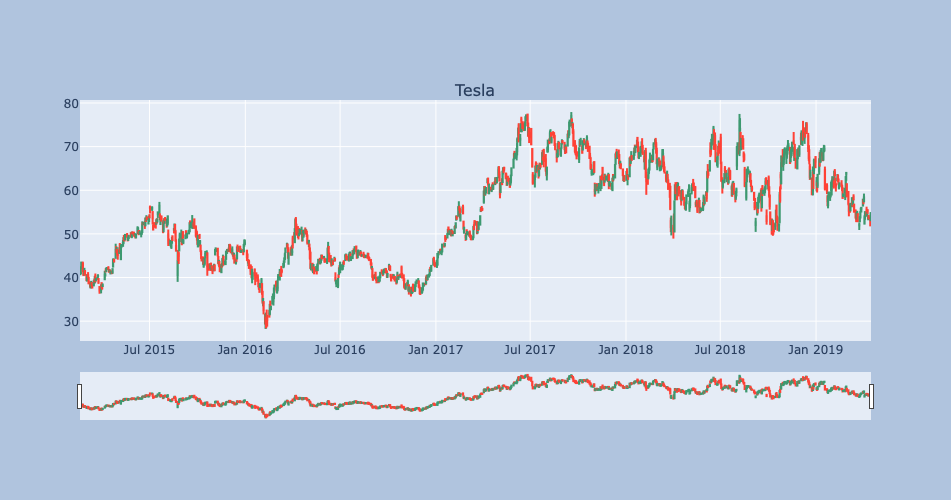

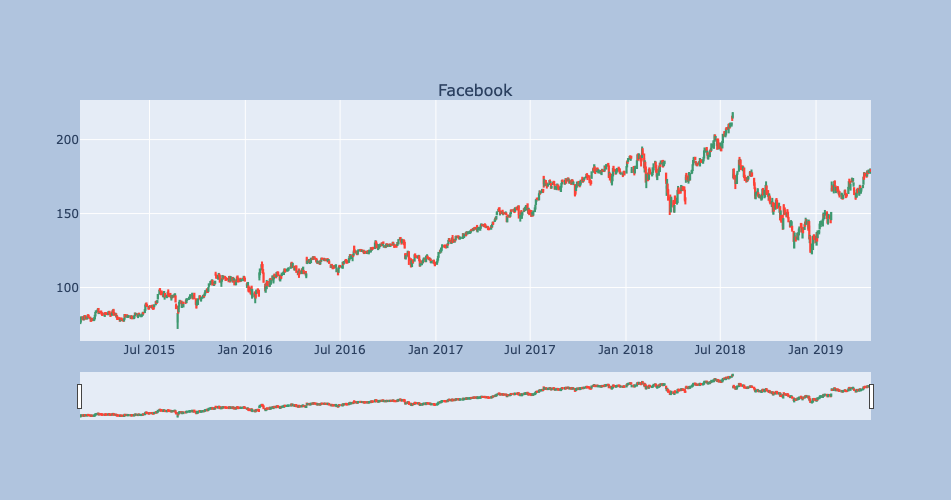

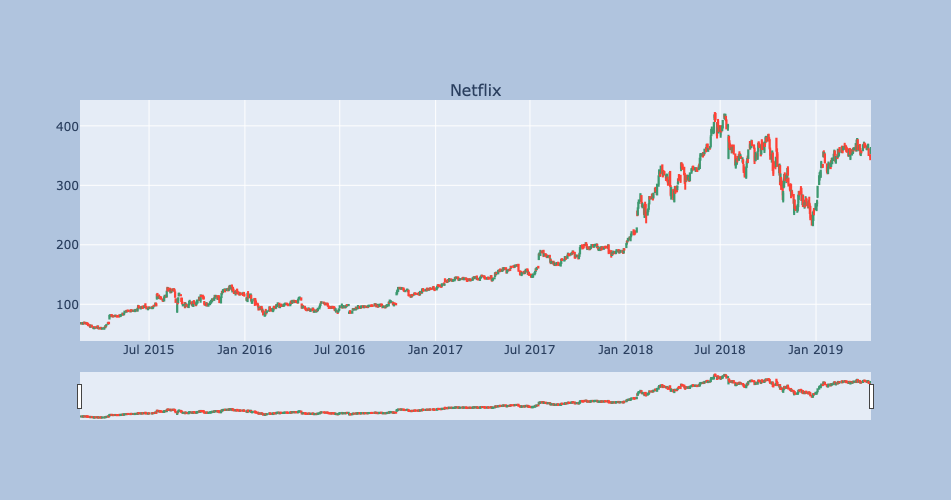

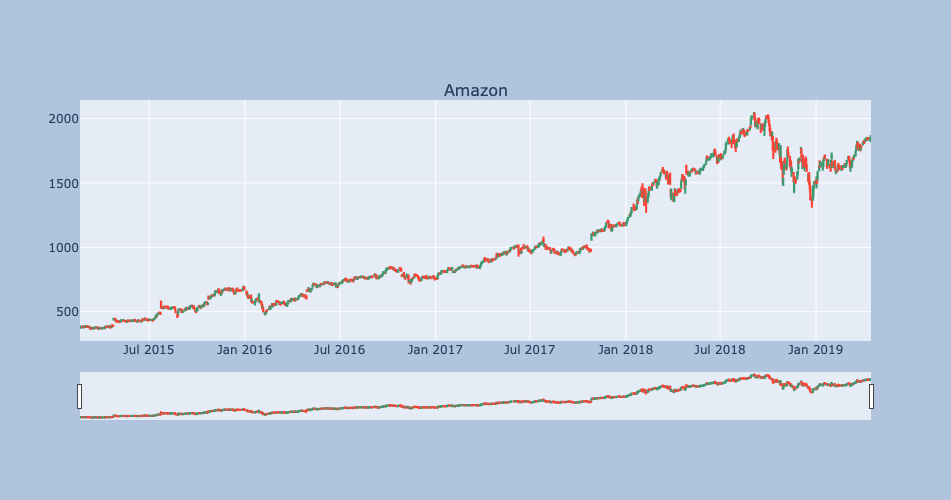

In [6]:
tesla = pd.read_csv('data/tesla_complete.csv').set_index('Date')
fb = pd.read_csv('data/facebook_completed.csv').set_index('Date')
nf = pd.read_csv('data/netflix_completed.csv').set_index('Date')
amzn = pd.read_csv('data/amazon_completed.csv').set_index('Date')

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 4. Plot of time series actual stock prices.
</b></center>'''))

for stock, title in zip([tesla, fb, nf, amzn], 
                        ['Tesla', 'Facebook', 'Netflix', 'Amazon']):
    show_candlesticks(stock, title)

<p style="text-align:justify">Most of the stock prices in the chosen companies increase during this period. Relating it to the results of the tone score that we got earlier. It seems that it follows a certain trend. For example, Tesla stock price started to get rocky at 2018 onwards similar to the tone score that the company got. Similarly, Netflix and Amazon experienced a drop at 2019 similar to the resutls of the tone score. It seems that there are some correlation between the two variables.</p>

## 6. Methodology

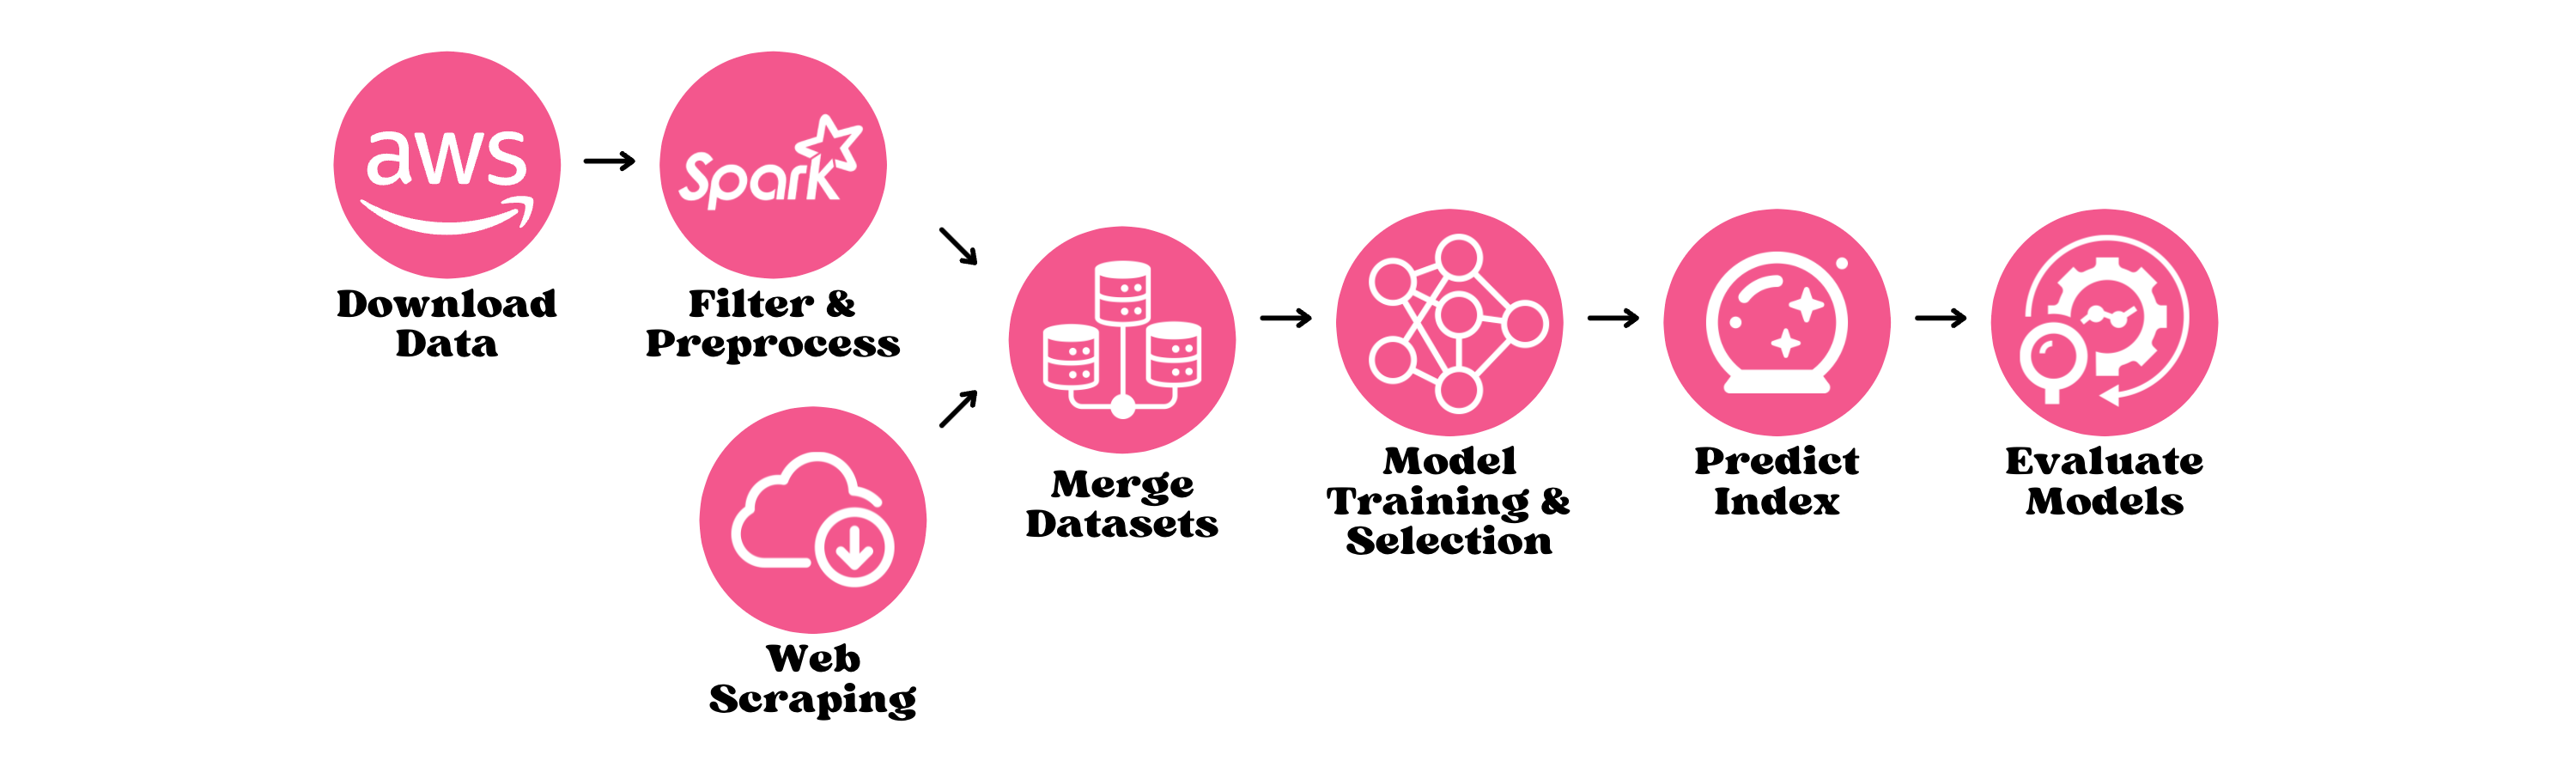

In [7]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 5. Methodology of the Project.
</b></center>'''))

display(_image(filename="img/methodology.png"))

### 6.1 Download GDELT Data from AWS Registry

<p style="text-align:justify">The GDELT dataset is publicly available in the Open Data Registry from AWS. The events dataset consists of csv files corresponding to 15 minute intervals of event recording .  A 4-instance EMR cluster was prepared for this study which includes 1 master and 3 core instances. The latest EMR release was used (6.5.0). The machines used are all m5.xlarge nodes with 4 cores, 16 GB memory each and EBS storage of 64GB. The EBS root volume size was set to 100 GB.</p>

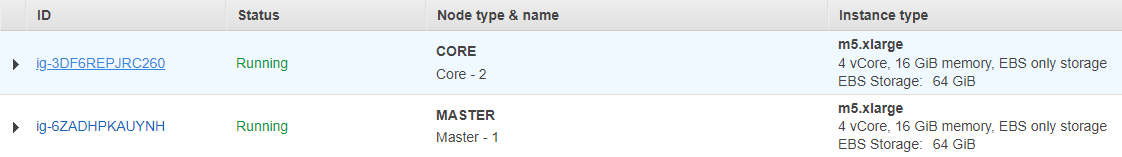

In [8]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 6. AWS Cluster Configuration.
</b></center>'''))

display(_image(filename="img/cluster.PNG"))

<p style="text-align:justify">Data preprocessing was done by creating several queries involving the chosen features. Several iterations were done for 4 companies named Tesla, Facebook, Netflix and Amazon. The company name was used as the search term or keyword and was checked as an entry for the actor names and the URL. After filtering using the keyword, information such as the date added and the corresponding average tone were extracted in order to be used for the study. Files were saved for each company pertaining to each date and their corresponding tone score for the entire date range of 2015 to 2019. For reference please see the GDELT download supplementary notebook.</p>

### 6.2 Filter and Preprocess: Mean & Cumulative Sum of Daily Tone

<p style="text-align:justify">Two types of average tone data were extracted from the main GDELT database. First was the mean daily tone which is a straightforward average of all tone score per day. The second was a cumulative daily tone which is a running 2 interval cumulative score computation for every available 15-minute update, and then averaged per day. This was done top get a feel of how the tone goes throughout the day.</p>

In [9]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 1. Sample output of the tone score.
</b></p>'''))

tesla_tone = pd.read_csv('data/tesla.csv')
display(tesla_tone.head())

DATEADDED  Daily Average Tone
0   20150218            4.000000
1   20150219            0.350000
2   20150220            0.021739
3   20150221            0.304348
4   20150222           -0.125000

### 6.3 Web Scraping: Yahoo Finance

<p style="text-align:justify">Yahoo Finance is one of the larges sources of stock quotes and other financial information that are being updated everyday. The team performed webscraping using yahoo finance <a href="https://pypi.org/project/yfinance/">api</a>. We scraped for the historical stock prices containing high, low, volume, open, and close of each day for the four companies that we wanted to explore namely: Facebook, Tesla, Netflix, and Amazon. </p>

In [10]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 2. Snippet of the output of yahoo finance.
</b></p>'''))

tesla = pd.read_csv('data/tesla_complete.csv')
display(tesla.iloc[:, :6].head())

Date       Open       High        Low      Close    Volume
0  2015-02-18  40.834000  41.234001  40.520000  40.891998  13568000
1  2015-02-19  41.000000  42.487999  40.750000  42.341999  25770500
2  2015-02-20  42.155998  43.520000  41.962002  43.422001  29910500
3  2015-02-23  43.132000  43.639999  41.265999  41.467999  42499000
4  2015-02-24  41.458000  41.458000  40.340000  40.821999  33018000

### 6.4. Combine Datasets

<p style="text-align:justify">After web scraping we computed for the technical indicators for each of the companies like MACD, Bollinger, RSI, and moving averages crossover. This will be used as a baseline of creating a trading strategy. This could also work in conjunction with the model that we developed. We then combined it with the average and cumulative tone score for each day that was scraped to GDELT.</p>

In [11]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 3. Merged dataset of stock prices, technical indicators, and tone score.
</b></p>'''))

display(tesla.head())

Date       Open       High        Low      Close    Volume  \
0  2015-02-18  40.834000  41.234001  40.520000  40.891998  13568000   
1  2015-02-19  41.000000  42.487999  40.750000  42.341999  25770500   
2  2015-02-20  42.155998  43.520000  41.962002  43.422001  29910500   
3  2015-02-23  43.132000  43.639999  41.265999  41.467999  42499000   
4  2015-02-24  41.458000  41.458000  40.340000  40.821999  33018000   

     RSI(14)        ma7     ma20      MACD  signal_line  bollinger_high  \
0  43.815253  41.772285  41.6841 -0.172222    -0.068098       44.590532   
1  52.319192  41.607428  41.8355 -0.108378    -0.076154       44.540819   
2  57.481252  41.630857  41.9904  0.029032    -0.055117       44.686553   
3  47.468180  41.474857  42.0509 -0.019517    -0.047997       44.641062   
4  44.696118  41.509999  42.0265 -0.108865    -0.060171       44.653059   

   bollinger_low  center_line         %K         %D  target  \
0      38.777668      41.6841  34.720485  33.892348       1   
1      39.130182      41.8355  57.236016  42.111793       1   
2      39.294247      41.9904  74.006224  55.320908       0   
3      39.460738      42.0509  43.664584  58.302275       0   
4      39.399941      42.0265  33.633533  50.434781       0   

   Daily Average Tone  
0            4.000000  
1            0.350000  
2            0.021739  
3            0.181818  
4            1.162791

### 6.5 Model Fitting (Classical ML, DL, Merlion)

<p style="text-align:justify">To run different time series pipelines simultaneously, different notebooks were employed for each type of model. Classical Machine Learning models include <code>k</code>-Nearest Neighbors, regression and ensemble models and is located in the <code>classical_ml.ipynb</code> file. For deep learning, a Recurring Neural Network called Long-Short Term Memory was used as a sequential time series prediction problem and is located in the <code>LSTM.ipynb</code> file. Lastly, Merlion, a Python library for time series intelligence provides an end-to-end machine learning framework that includes automatically loading and transforming data, building and training models, post-processing model outputs, and evaluating model performance, was used in the time series prediction and is located in the <code>merlion</code> folder. Merlion is a comprehensive Machine Learning library which aggregates multiple features from different existing packages for Time Series Analysis. </p>

<p style="text-align:justify">For each model, three situations were considered: (1) base prediction where only <code>Close</code> was the only feature used in prediction, (2) prediction using <code>Close</code> and <code>Mean</code> Daily Average Tone was included and (3) prediction using <code>Close</code> and <code>Cumulative Sum</code> Daily Average Tone was used. For each of these models as well, three prediction windows were determined: <code>1</code>-day, <code>3</code>-day and <code>5</code>-day. This makes a total of 9 iterations already for a single model. A total of 12 models were used. This was also done for each dataset for a total of 432 optimal models in total.</p>

<p style="text-align:justify">Mean Absolute Error (MAE) was the metric used to evaluate all of the models. It was used to company the actual historical values with the model's predicted values for ease of interpretability. This metric is readily interpretable because the unit is in dollars. </p>


#### A. Classical ML

<p style="text-align:justify">List of the models used:</p>

- <code>k</code>-Nearest Neighbors Regressor
- Linear SVM (L1)
- Linear SVM (L2)
- Logistic Regression (L1)
- Logistic Regression (L2)
- Decision Tree
- Random Forest
- Gradient Boosting Method

#### B. Deep Learning

<p style="text-align:justify">List of the models used:</p>

- LSTM Neural Network

#### C. Merlion

<p style="text-align:justify">List of the models used:</p>

- Merlion Forecaster
- AutoRegressive Integrated Moving Average (ARIMA)
- Ensemble Forecaster

## 7. Results and Discussion

### 7.1 Best Model

<p style="text-align:justify">Only the best model out of all 12 was used. This was determined to be the <b>Merlion forecaster</b>. Its own DefaultForecaster model is simple to use but provides robust results with seasonality detection and hyperparameter tuning are built into the the model. </p>

<p style="text-align:justify">The authors used this forecaster as a benchmark to predict the impact that media tone has on several company stocks. Through webscraping, the team aggregated the closing stock prices of several companies such as Tesla, Facebook, Netflix, and Amazon. The aggregated media tone in the form of its average and cumulutive sum were added as a feature for forecasting the stock's closing price for each company. Each dataset was split into a 80% Train and 20% Test set which the forecaster generated predictions for. Predictions for each company's stock was generated in 1, 3, and 5 day sliding windows with the last value of each window being used as the predicted value as a trading strategy. </p>

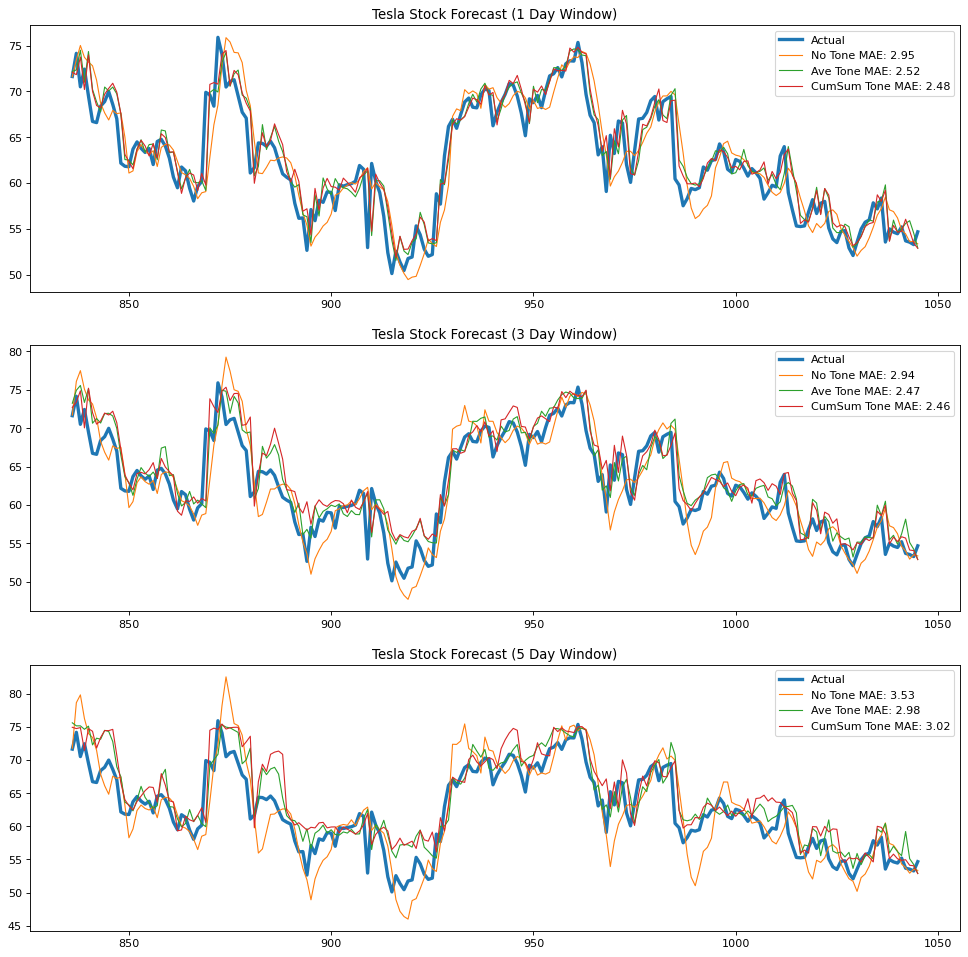

In [12]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 7. Predictions for Tesla Stock using 1-, 3-, 5-day windows.
</b></center>'''))

display(_image(filename="img/tesla.png"))

For Tesla, we see a decrease in MAE using Tone in all types of prediction windows. Out of these as well, we see that the 3-day window is also the best in terms of MAE.

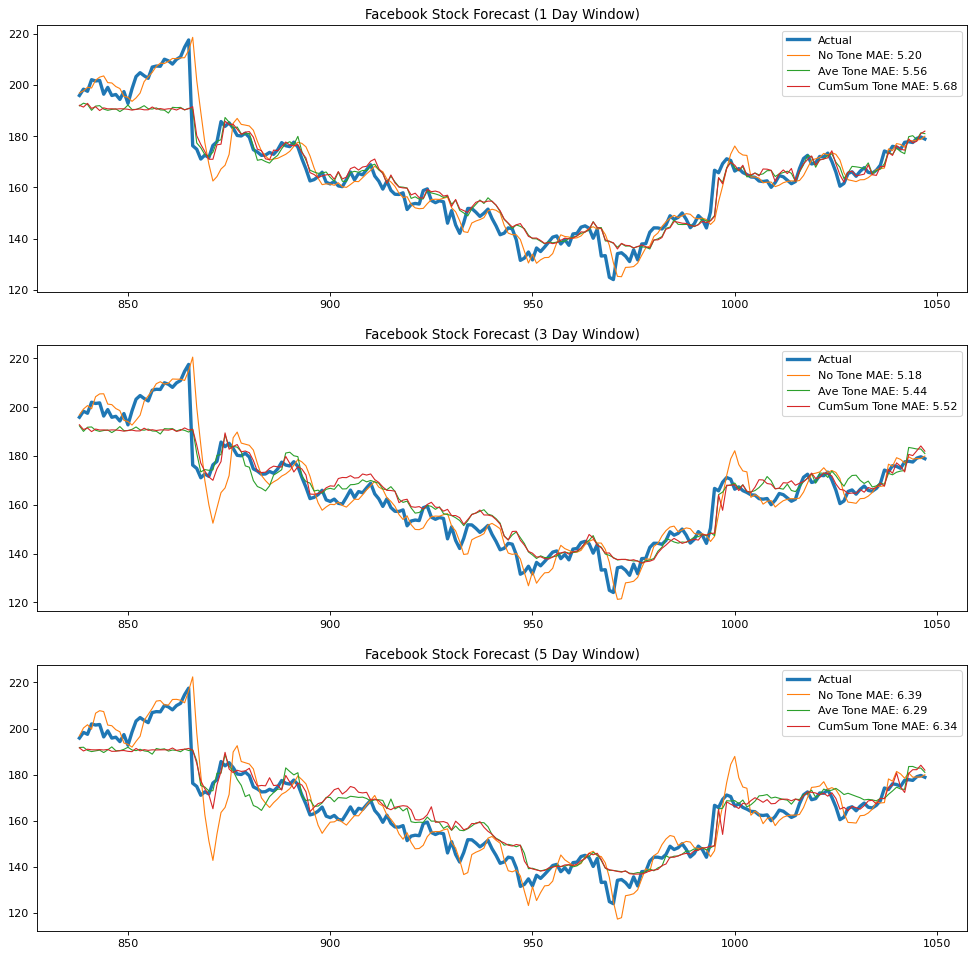

In [13]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 8. Predictions for Facebook Stock using 1-, 3-, 5-day windows.
</b></center>'''))

display(_image(filename="img/facebook.png"))

For Facebook stock, only the 3-day and 5-day windows had improvements by adding Tone.

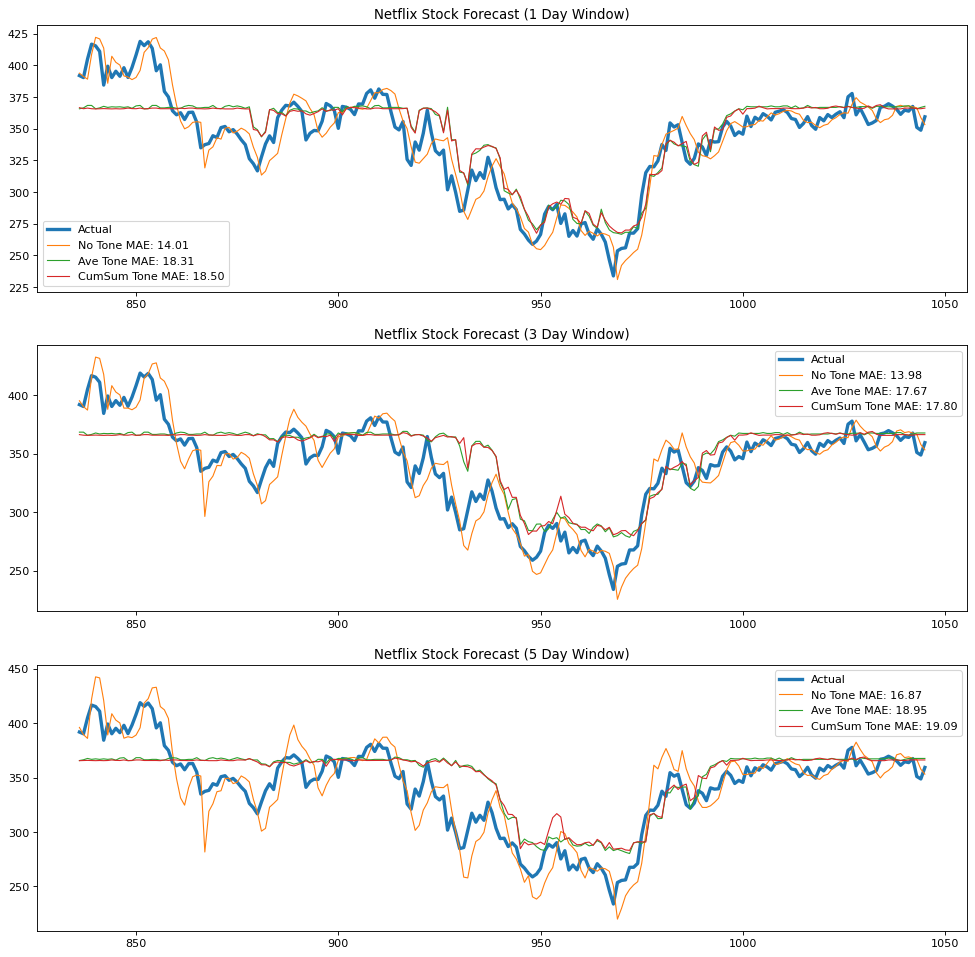

In [14]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 9. Predictions for Netflix Stock using 1-, 3-, 5-day windows.
</b></center>'''))

display(_image(filename="img/netflix.png"))

In general, we did not even consider evaluating Netflix and Amazon due to the large MAE of their stock from the No Tone models. In general, if the stocks have high MAEs from the base model alone, we expect that adding Tone may not necessarily improve it.

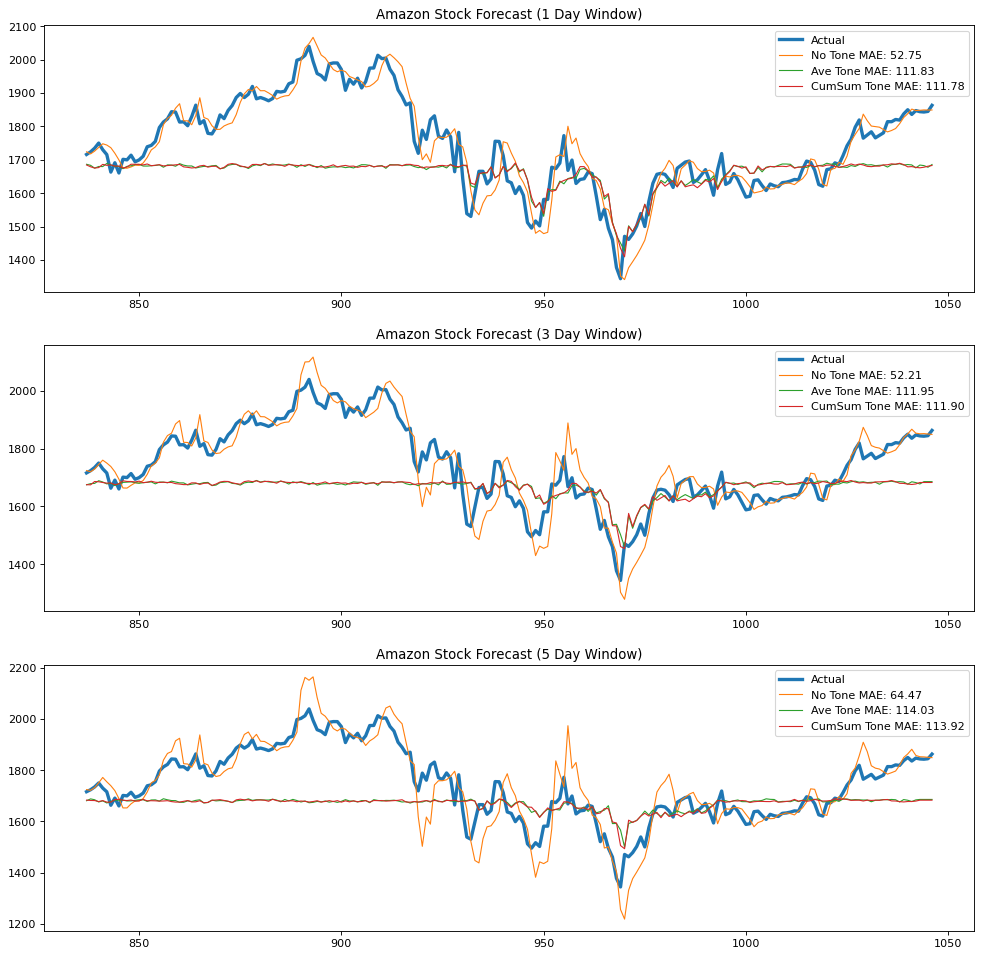

In [15]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 10. Predictions for Amazon Stock using 1-, 3-, 5-day windows.
</b></center>'''))

display(_image(filename="img/amazon.png"))

Other results from the other types of models can be viewed in the other notebooks attached as Appendices.

### 7.2. Backtesting

<p style="text-align:justify">We evaluate our model further by performing backtesting. We start off by using a classical strategy of using the crossover of fast and slow moving average to decide when to buy or sell. To perform backtesting we used <code>backtesting</code> Python library.</p>

In [16]:
df_full = pd.read_csv('data/tesla_complete.csv')
with open(r"data/day5strat.p", "rb") as input_file:
    e = pickle.load(input_file)
    
df_bt = df_full[-210:].copy()
df_bt['y_pred'] = e.Pred.to_list()
df_bt = df_bt.set_index('Date')
df_bt.index = pd.to_datetime(df_bt.index)

In [17]:
class SmaCross(Strategy):
    def init(self):
        self.close = self.data.Close
        self.ma1 = self.I(SMA, self.close, 10)
        self.ma2 = self.I(SMA, self.close, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()      

In [18]:
bt = Backtest(df_bt.loc['2018-06-15':'2019-04-16'], SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
display(stats)

Start                     2018-06-15 00:00:00
End                       2019-04-16 00:00:00
Duration                    305 days 00:00:00
Exposure Time [%]                   82.380952
Equity Final [$]                  3832.551531
Equity Peak [$]                  10207.641229
Return [%]                         -61.674485
Buy & Hold Return [%]              -23.678702
Return (Ann.) [%]                  -68.363706
Volatility (Ann.) [%]               19.148195
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -66.387312
Avg. Drawdown [%]                  -41.934978
Max. Drawdown Duration      221 days 00:00:00
Avg. Drawdown Duration      126 days 00:00:00
# Trades                                   13
Win Rate [%]                        23.076923
Best Trade [%]                      15.263393
Worst Trade [%]                    -21.005974
Avg. Trade [%]                    

<p style="text-align:justify">We got a result of -68% using the classical method. This is understandable since our test set belongs to the bearish market of Tesla which is during 2018.</p>

<p style="text-align:justify">Next, we used our best machine learning model which is Merlion. We used the 3 day window as it performs best with our model and also because it would give enough time for the difference between stocks to go up. We do not want to have a very volatile outputs as we will become too sensitive from the market change.</p>

In [19]:
class ModelStrategy(Strategy):
    def init(self):
        self.pred = self.data.y_pred
        self.close = self.data.Close
        
        self.ma1 = self.I(SMA, self.close, 10)
        self.ma2 = self.I(SMA, self.close, 20)

    def next(self):
        pct = (abs(((self.pred - self.close)/self.close)*100) > 2)
        if ((self.pred - self.close > 0) and pct):
            self.buy()
        elif ((self.pred - self.close <= 0) and pct):
            self.sell()            

bt = Backtest(df_bt.loc['2018-06-15':'2019-04-16'], ModelStrategy, 
              commission=.002,
              exclusive_orders=True)
stats = bt.run()
display(stats)

Start                     2018-06-15 00:00:00
End                       2019-04-16 00:00:00
Duration                    305 days 00:00:00
Exposure Time [%]                        90.0
Equity Final [$]                  5904.424127
Equity Peak [$]                  10319.441453
Return [%]                         -40.955759
Buy & Hold Return [%]              -23.678702
Return (Ann.) [%]                  -46.861039
Volatility (Ann.) [%]               34.369695
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -46.663992
Avg. Drawdown [%]                  -18.666413
Max. Drawdown Duration      260 days 00:00:00
Avg. Drawdown Duration       91 days 00:00:00
# Trades                                  189
Win Rate [%]                        45.502646
Best Trade [%]                      13.454271
Worst Trade [%]                    -14.318912
Avg. Trade [%]                    

<p style="text-align:justify">Using our model alone, we were able to get a lower negative return. It means that it performs better than having crossover moving averages standalone. We then explore on combining the two methods.</p>

In [20]:
class ModelSmaCross(Strategy):
    def init(self):
        self.pred = self.data.y_pred
        self.close = self.data.Close
        
        self.ma1 = self.I(SMA, self.close, 10)
        self.ma2 = self.I(SMA, self.close, 20)

    def next(self):
        pct = (abs(((self.pred - self.close)/self.close)*100) > 2)
        if (((self.pred - self.close > 0) and pct) 
              and crossover(self.ma1, self.ma2)):
            self.buy()
        elif (((self.pred - self.close <= 0) and pct) 
              and crossover(self.ma2, self.ma1)):
            self.sell()            

bt = Backtest(df_bt.loc['2018-06-15':'2019-04-16'], ModelSmaCross, 
              commission=.002,
              exclusive_orders=True)
stats = bt.run()
display(stats)

Start                     2018-06-15 00:00:00
End                       2019-04-16 00:00:00
Duration                    305 days 00:00:00
Exposure Time [%]                   76.666667
Equity Final [$]                  9036.495135
Equity Peak [$]                  12168.356301
Return [%]                          -9.635049
Buy & Hold Return [%]              -23.678702
Return (Ann.) [%]                  -11.447664
Volatility (Ann.) [%]               56.175469
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.921129
Avg. Drawdown [%]                  -14.354714
Max. Drawdown Duration      190 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                    6
Win Rate [%]                        66.666667
Best Trade [%]                       20.24898
Worst Trade [%]                    -39.754542
Avg. Trade [%]                    

<p style="text-align:justify">Combining the machine learning model and the moving averages crossover we were able to get a lesser negative return in a bearish market.</p>

## 8. Conclusion

<p style="text-align:justify">Inclusion of tone can give improvements to prediction models for stock index even if the keywords only refer to a certain company name. This can be an objective and numerical representation of how the market perceives the company which is a reflection of systematic risk. However, this comes at a caveat that the company needs to have a strong public presence so that they are constantly mentioned in the GDELT database. Furthermore, time series models, specifically Merlion Forecaster, performs the best in predictions. Tesla specifically has a polarizing CEO. This kind of celebrity in their management maybe a better determinant of tone rather than one that is relatively quiet.</p>

<b>Feature engineering: Mean vs Cumulative Sum</b>
<p style="text-align:justify">The cumulative sum tends to emphasize the tone more than the mean so different companies will have different ways to represent tone. Further study can be made on feature engineering and what will maximize the value of tone for a company.</p>


<b>Prediction Windows</b>
<p style="text-align:justify">The general trend of results point to a <b>3-day</b> window as the best choice, a possible indication of the late effect of media sentiment, 1-day may be too soon and 5-day might be too long.</p>

<b>Company Profiles</b>
<p style="text-align:justify">The authors determined two types of companies based on their base MAE. Only the smaller base errors can be effectively applied with tone. Tesla and Facebook had low values for MAE while Netflix and Amazon had larger values for MAE.</p>

## 9. Recommendations

<p style="text-align:justify">For the study, only the company name was used as a keyword or search term when scanning the GDELT database for articles that may relate to the target company. This may be improved by augmenting the choice of keywords to include topics related to the industry and index the company belongs too. Other keywords such as know icon or personalities associated with the company could also be included as a part of the multi-search term list. For example, if we were to expand the keywords for Tesla, we could include words such as self-driving, renewables, Elon Musk and the like or if we have oil companies such as Chevron as a target, we can include petroleum, natural gas, fracking, etc.</p>

<p style="text-align:justify">Since the GDELT database is being updated every 15 minutes, we could also explore the possibility of using a dataset with hourly granularity or one with a longer-range such as weekly. Other stock information could also be integrated aside from the closing price. The effect of each feature could be assessed and if viable, will be added to improve predicting capabilities. Also, other models could be explored to see if another one could outperform the merlion forecaster used in the study. Improving the current model with hyperparameter tuning could also contribute in its improvement.</p>

<p style="text-align:justify">More preprocessing steps related to time series forecasting should also be considered to improve MAE scores.</p>

<p style="text-align:justify">Lastly, since not all companies are directly suitable, increasing the variety of companies tested will complete the whole picture and improve the profiling of companies that could be analyzed using this method. A better understanding could be built over what type of companies could be associated to media sentiment changes.</p>

## References

[1] GDELT Project. https://www.gdeltproject.org/about.html

[2] GDELT Project (2015) "GDELT Event Codebook". http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf

[3] Chen J. (2022), "Systematic Risk", https://www.investopedia.com/terms/s/systematicrisk.asp

[4] Corporate Finance Institute. "Systematic Risk" https://corporatefinanceinstitute.com/resources/knowledge/finance/systematic-risk/